# Classification based on Quickdraw Dataset

### Imports

In [1]:
import os
from PIL import Image
import json

import random
import numpy as np
import cairocffi as cairo
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.optim.lr_scheduler import StepLR

### Functions to preprocess the data

In [3]:
# Get the classes that will be used
def load_classes(file_path):
    res = {}
    count = 0
    for line in open(file_path, 'r'):
        res[count] = line.rstrip()
        count+=1
    return res

In [4]:
### The code is taken from the original GitHub of the QuickDrawDataset
def vector_to_raster(vector_images, side=64, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [5]:
# return the data as an array containing images as 1D arrays
def load_data(sample, n_images, dimension):
    sample_data = [json.loads(line) for line in open(f'data/full_simplified_{sample}.ndjson', 'r')]
    sample_data = random.sample(sample_data, k=n_images)
    vector_images = [drawing_data['drawing'] for drawing_data in sample_data]
    return np.array(vector_to_raster(vector_images, side=dimension))

In [6]:
# Saves the datasets as images in the "images" folder
def save_png(drawing_class, data, dimension):
    if not os.path.exists(f"images/{drawing_class}"): 
        os.makedirs(f"images/{drawing_class}")

    count = 0
    for image_arr in data:
        image_arr = np.reshape(image_arr, (dimension, -1))
        img = Image.fromarray(image_arr, "L")
        img.save(f"images/{drawing_class}/{drawing_class}_{count}.png")
        count += 1
    

In [17]:
def preprocess_data(classes, n_images, img_dim, train_prop=0.8):
  train_file_names = []
  train_labels = []
  test_file_names = []
  test_labels = []
  
  for key, drawing_class in classes.items():
      print(f"Loading {drawing_class} data")
      data = load_data(drawing_class, n_images, dimension = img_dim)
      save_png(drawing_class, data, img_dim)
      file_names = [f"images/{drawing_class}/{drawing_class}_{i}.png" for i in range(len(data))]
      labels = np.full(len(data), key)
      train_file_names.append(file_names[:(int)(n_images*train_prop)])
      train_labels.append(labels[:(int)(n_images*train_prop)])
      test_file_names.append(file_names[(int)(n_images*train_prop):])
      test_labels.append(labels[(int)(n_images*train_prop):])

  # Save the file names and labels
  train_file_names = np.array(train_file_names).flatten()
  json.dump(train_file_names.tolist(), open("train_file_names.json", 'w'))
  train_labels = np.array(train_labels).flatten()
  json.dump(train_labels.tolist(), open("train_labels.json", 'w'))
  test_file_names = np.array(test_file_names).flatten()
  json.dump(test_file_names.tolist(), open("test_file_names.json", 'w'))
  test_labels = np.array(test_labels).flatten()
  json.dump(test_labels.tolist(), open("test_labels.json", 'w'))

In [18]:
def calcMeanStd(datasets):
    data = []
    for dataset in datasets:
        for file_name in dataset:
            img = Image.open(file_name)
            img = np.array(img)
            data.append(img)
    data = np.array(data)
    return np.mean(data), np.std(data)

### Dataset class that represent the Dataset

In [8]:
class QuickDrawDataset(Dataset):
    def __init__(self, file_names, labels, transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.file_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### Functions for the CNN

In [9]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) # To increase maybe to 16
        self.conv2 = nn.Conv2d(8, 16, 3)# To increase maybe to 32
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(400, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [10]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    return losses

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return [test_loss]

### Main part

Variables describing the data

In [13]:
# Images will be 64x64
img_dim = 28
# Number of images taken for each animal
n_images = 1000
# Proportion used for to train the model
train_prop = 0.8
learning_rate = 1
gamma = 0.7

Store the classes in a dictionnary with their index

In [14]:
classes = load_classes("class_names.txt")
n_classes = len(classes)
print(classes)

{0: 'axe', 1: 'bicycle'}




The preprocess function do multiple thingd : <br>
- Build the png images from the json files. Like this the PyTorch Dataset object will search the images directly in the files
- Separate the dataset in train and test datasets by storing the names of the 
- Process the mean and the standard deviation and return it to later normalize the datasets

In [16]:
preprocess_data(classes, n_images=n_images, img_dim=img_dim, train_prop=train_prop, save_images = False)

train_files = json.load(open("train_file_names.json", 'r'))
test_files = json.load(open("test_file_names.json", 'r'))

train_labels = json.load(open("train_labels.json", 'r'))
test_labels = json.load(open("test_labels.json", 'r'))


Loading axe data
Loading bicycle data


In [19]:
mean, std = calcMeanStd([train_files, test_files])

Create the Datasets

In [20]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

preprocessNoNorm = transforms.Compose([
        transforms.ToTensor(),
        ])

train_dataset = QuickDrawDataset(train_files, train_labels, transform=preprocessNoNorm)
test_dataset = QuickDrawDataset(test_files, test_labels, transform=preprocessNoNorm)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [21]:
image = Image.open("images/axe/axe_0.png")
image = preprocess(image)
print(image.shape)

torch.Size([1, 28, 28])


In [24]:
model = Net(n_classes)

optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 12
log_interval = 500
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_losses += train(model, device, train_loader, optimizer, epoch, log_interval)
    loss = test(model, device, test_loader)
    test_losses.append(loss)
    scheduler.step()

Train Epoch: 1 [0/1600 (0%)]	Loss: 0.799649
Train Epoch: 1 [500/1600 (31%)]	Loss: 0.924322
Train Epoch: 1 [1000/1600 (62%)]	Loss: 0.001329
Train Epoch: 1 [1500/1600 (94%)]	Loss: 0.000002

Test set: Average loss: 0.0667, Accuracy: 392/400 (98%)

Train Epoch: 2 [0/1600 (0%)]	Loss: 0.000005
Train Epoch: 2 [500/1600 (31%)]	Loss: 0.000041
Train Epoch: 2 [1000/1600 (62%)]	Loss: 0.000000
Train Epoch: 2 [1500/1600 (94%)]	Loss: 0.013753

Test set: Average loss: 0.0581, Accuracy: 393/400 (98%)

Train Epoch: 3 [0/1600 (0%)]	Loss: 0.000001
Train Epoch: 3 [500/1600 (31%)]	Loss: 0.000405
Train Epoch: 3 [1000/1600 (62%)]	Loss: 0.006745
Train Epoch: 3 [1500/1600 (94%)]	Loss: 0.001340

Test set: Average loss: 0.0440, Accuracy: 395/400 (99%)

Train Epoch: 4 [0/1600 (0%)]	Loss: 0.000034
Train Epoch: 4 [500/1600 (31%)]	Loss: 3.028986
Train Epoch: 4 [1000/1600 (62%)]	Loss: 0.000047
Train Epoch: 4 [1500/1600 (94%)]	Loss: 0.000054

Test set: Average loss: 0.0550, Accuracy: 392/400 (98%)

Train Epoch: 5 [0/16

KeyboardInterrupt: 

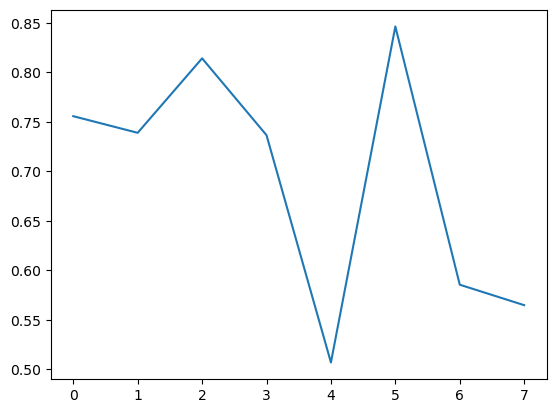

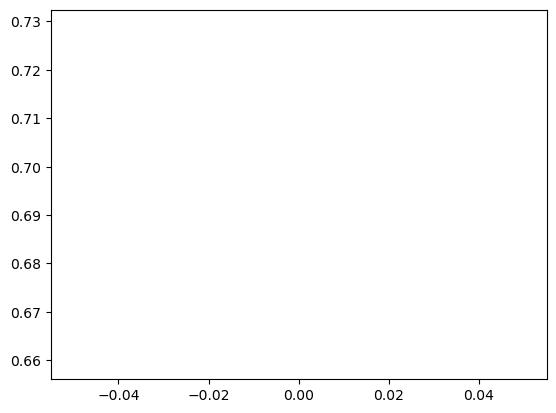

In [37]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.show()

For the datas :
- sort to keep only the recognized drawings

For the CNN:
- (batch normailzation)
- conv relu pooling conv relu pooling dropout

For vizualization and documentation:
- learning rate
- batch size
- number of epochs

- Confusion Matrix
- evolution of the error with epochs


### The model